In [126]:
import snowflake.connector
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='username',
    password='password',
    account='qxb48102',
    warehouse='COMPUTE_WH',
    database='SPOTIFYPLAYLIST_DW',
    schema='SPOTIFYPLAYLIST_DW_SCHEMA',
    role='ACCOUNTADMIN'
)

# Query the data
query = """
    SELECT 
        s.song_id,
        s.song_name,
        s.duration_ms,
        s.popularity,
        s.song_added,
        a.name AS album_name,
        a.release_date,
        a.total_tracks,
        ar.artist_name
    FROM 
        song s
    JOIN 
        album a ON s.album_id = a.album_id
    JOIN 
        artist ar ON s.artist_id = ar.artist_id;
"""
df = pd.read_sql(query, conn)

C:\Users\spava\AppData\Local\Temp\ipykernel_11540\1548356228.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [128]:
# Display the first few rows
df.head()

,SONG_ID,SONG_NAME,DURATION_MS,POPULARITY,SONG_ADDED,ALBUM_NAME,RELEASE_DATE,TOTAL_TRACKS,ARTIST_NAME
0,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga
1,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga
2,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga
3,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga
4,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga


In [129]:
# Remove Duplicates
df = df.drop_duplicates()

# Handle Missing Values
print(df.isnull().sum())
df = df.fillna(0)  # Replace missing values with 0

SONG_ID         0
SONG_NAME       0
DURATION_MS     0
POPULARITY      0
SONG_ADDED      0
ALBUM_NAME      0
RELEASE_DATE    0
TOTAL_TRACKS    0
ARTIST_NAME     0
dtype: int64


In [130]:
# Feature Engineering
df['song_added_year'] = pd.to_datetime(df['SONG_ADDED']).dt.year
df['release_year'] = pd.to_datetime(df['RELEASE_DATE']).dt.year
df['release_month'] = pd.to_datetime(df['RELEASE_DATE']).dt.month

# Convert Song Duration from Milli Seconds to Minutes
df['duration_minutes'] = df['DURATION_MS'] / 60000

In [131]:
# Normalize Features
scaler = MinMaxScaler()
df[['DURATION_MS', 'TOTAL_TRACKS', 'duration_minutes']] = scaler.fit_transform(
    df[['DURATION_MS', 'TOTAL_TRACKS', 'duration_minutes']]
)

In [132]:
# Encode Categorical Variables
df = pd.get_dummies(df, columns=['ALBUM_NAME', 'ARTIST_NAME'], drop_first=True)

In [133]:
# Drop Redundant Columns
X = df.drop(columns=['POPULARITY', 'SONG_ID', 'SONG_NAME', 'SONG_ADDED', 'RELEASE_DATE'])
y = df['POPULARITY']

In [134]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 52.1501474783862
R2 Score: 0.6186603474462106


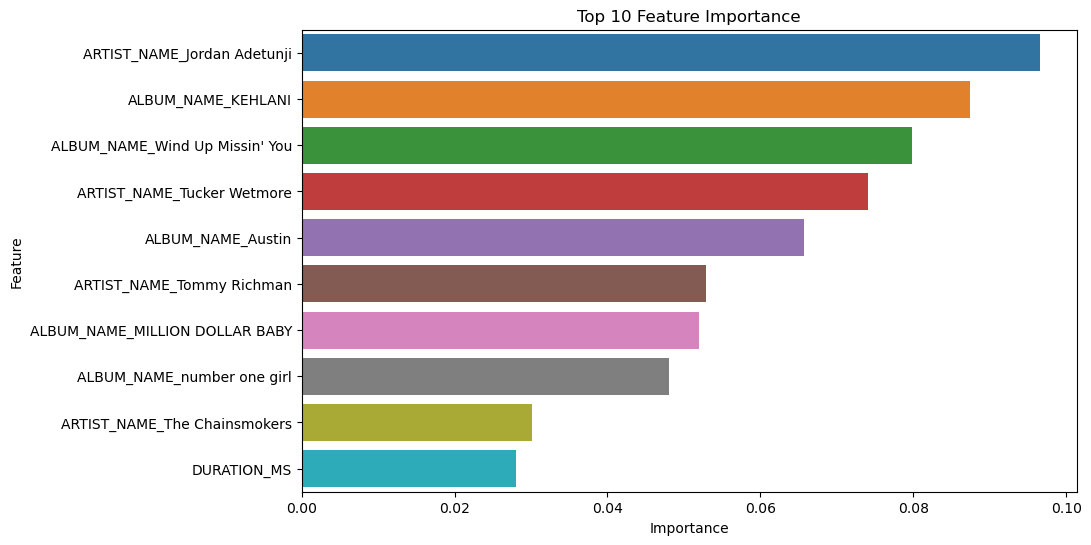

In [136]:
# Sort and select top 10 features
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance')
plt.show()


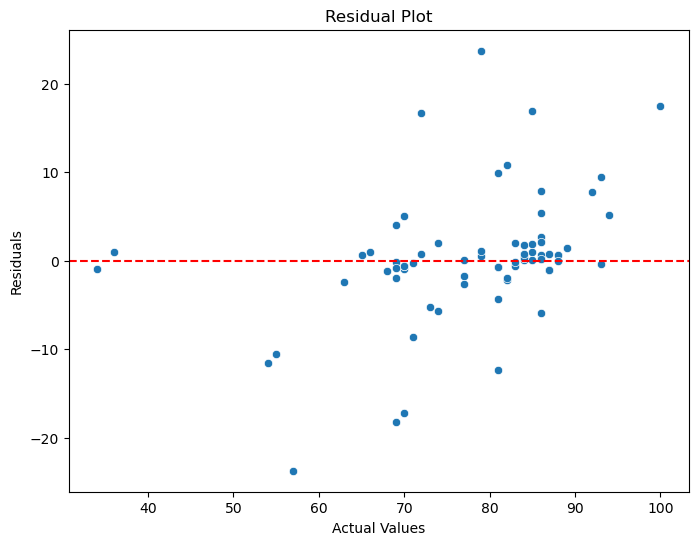

In [137]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


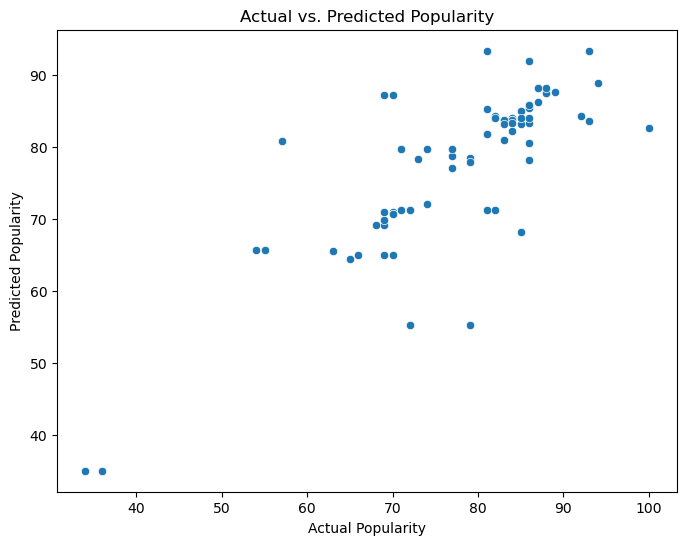

In [138]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Actual vs. Predicted Popularity")
plt.show()